In [1]:
%load_ext autoreload
%autoreload 2

In [80]:
import numpy as np

import pymc3 as pm

from modules.models.chapter_5 import estimate_pearson_correlation, estimate_k_coef_agreement, estimate_change_point
from modules.models.chapter_5 import estimate_censored_data, estimate_recapture

from modules.utils import validate_model, visualize_biv_samples, visualize_samples, visualize_time_series

In [71]:
PRPC_KWARGS={
    'samples': 1000
}
SAMPLING_KWARGS={
    'draws': 1000,
    'tune': 3000,
}
POPC_KWARGS={
    'samples': 1000
}

# Estimate Pearson Correlation

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, Cholesky decomposition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\density_utils.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\density_utils.py:252: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\density_utils.py:276: RuntimeWarning: invalid value encountered in double_scalars
  bw = (_bw_silverman(x) / np.ptp(x)) ** 2
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\density_utils.py:760: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your d

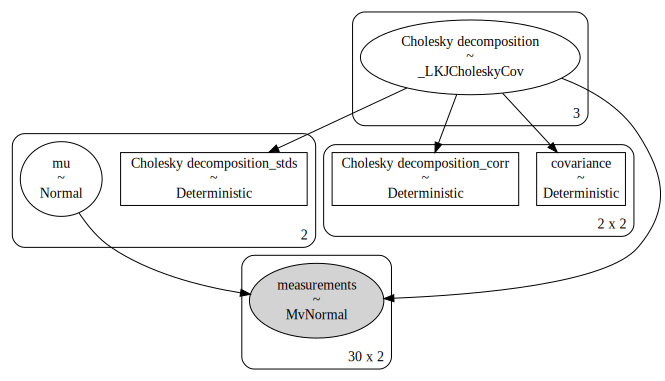

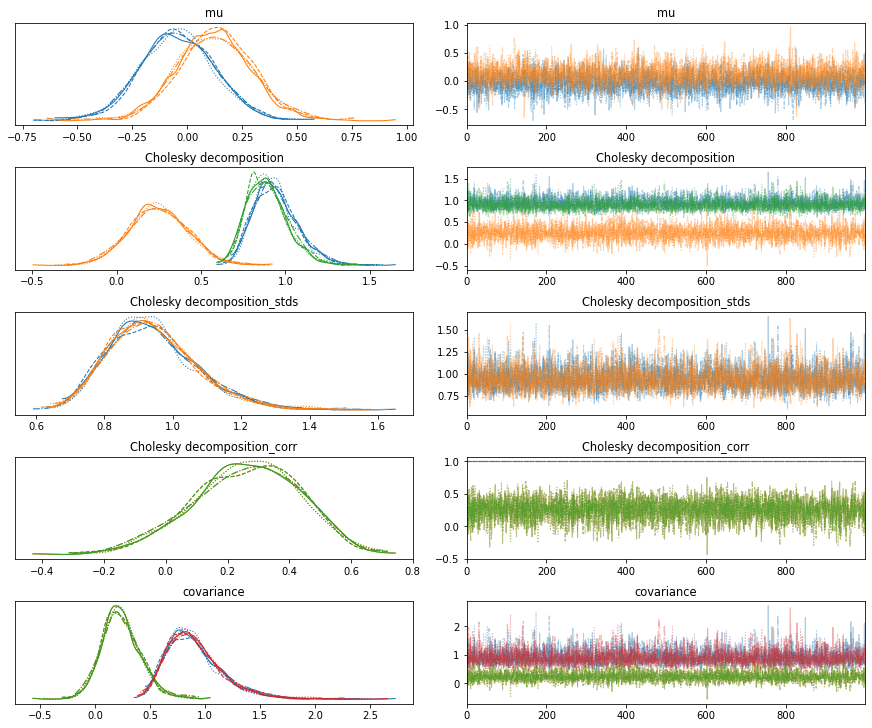

In [20]:
corr = 0.5
obs_measurements = np.random.multivariate_normal(
    mean=[0, 0],
    cov = [[1, corr], [corr, 1]],
    size=30
)

model = estimate_pearson_correlation(
    obs_measurements=obs_measurements, 
    lkj_chol_kwargs={
        'eta': 1,
        'sd_dist': pm.HalfCauchy.dist(25)
    }, 
    mu_kwargs={
        'mu': 0,
        'sigma': 1
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

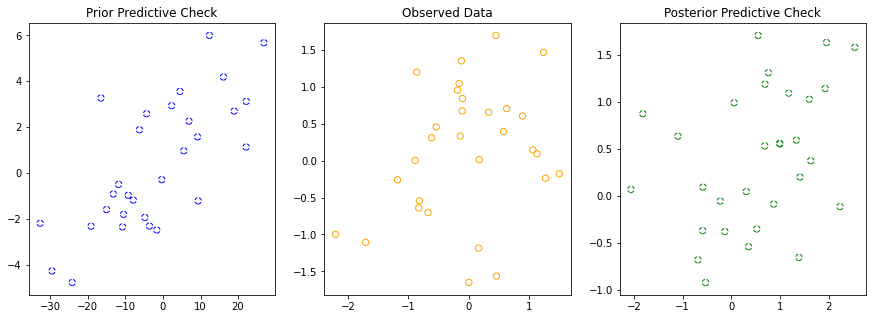

In [21]:
visualize_biv_samples(
    observed=obs_measurements, 
    prpc=prpc['measurements'][0, :, :], 
    popc=popc['measurements'][0, :, :],
    s=40
)

## Estimate Correlation for noisy data

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [measurements_error, latent_measurements, mu, Cholesky decomposition]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 326 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8770082525856754, but should be close to 0.95. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8201300106898702, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws an

C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\density_utils.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\density_utils.py:252: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\density_utils.py:276: RuntimeWarning: invalid value encountered in double_scalars
  bw = (_bw_silverman(x) / np.ptp(x)) ** 2
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\density_utils.py:760: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\arviz\stats\density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your d

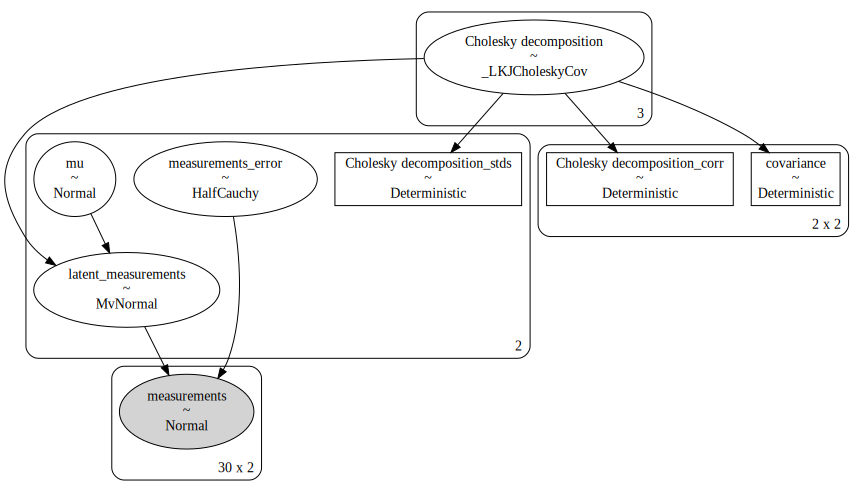

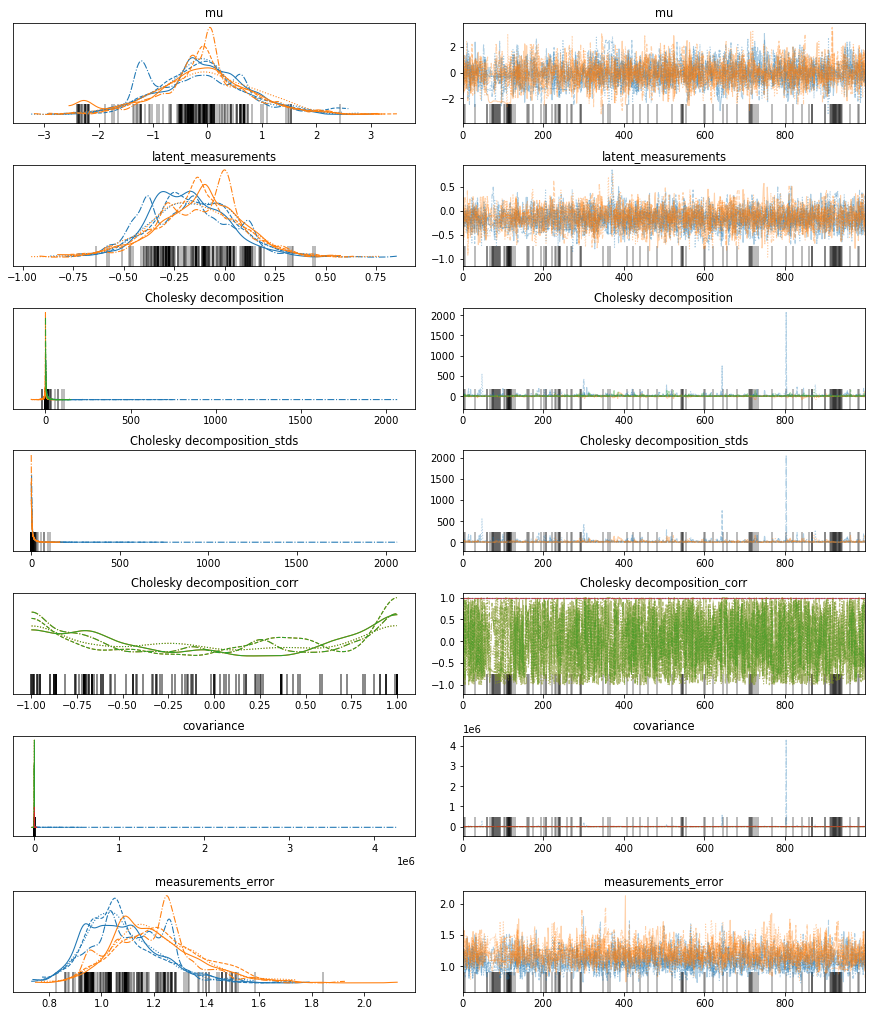

In [29]:
corr = 0.5
obs_measurements = np.random.multivariate_normal(
    mean=[0, 0],
    cov = [[1, 1*corr], [1*corr, 1]],
    size=30
)
obs_measurements += np.random.normal(0, 1, size=(30, 2))

model = estimate_pearson_correlation(
    obs_measurements=obs_measurements, 
    lkj_chol_kwargs={
        'eta': 1,
        'sd_dist': pm.HalfCauchy.dist(25)
    }, 
    mu_kwargs={
        'mu': 0,
        'sigma': 1
    },
    sigma_kwargs={
        'beta': 25
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

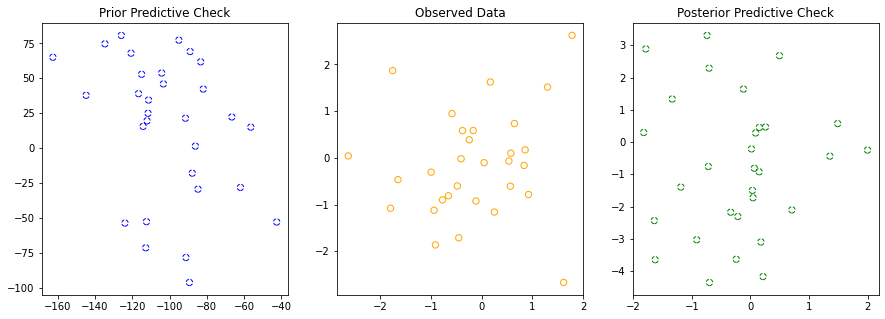

In [30]:
visualize_biv_samples(
    observed=obs_measurements, 
    prpc=prpc['measurements'][0, :, :], 
    popc=popc['measurements'][0, :, :],
    s=40
)

# Estimate K Coefficient of agreement between judges

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, beta, alpha]
INFO:pymc3:NUTS: [gamma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


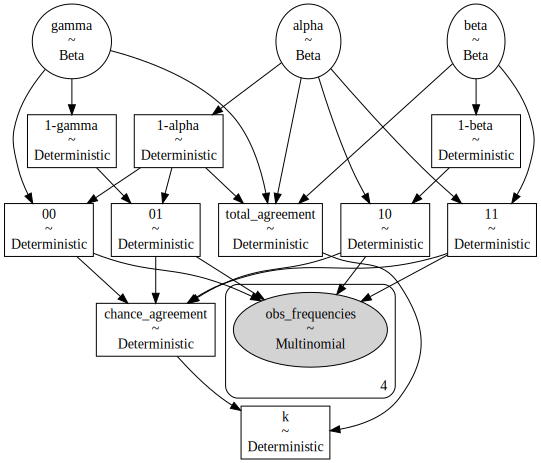

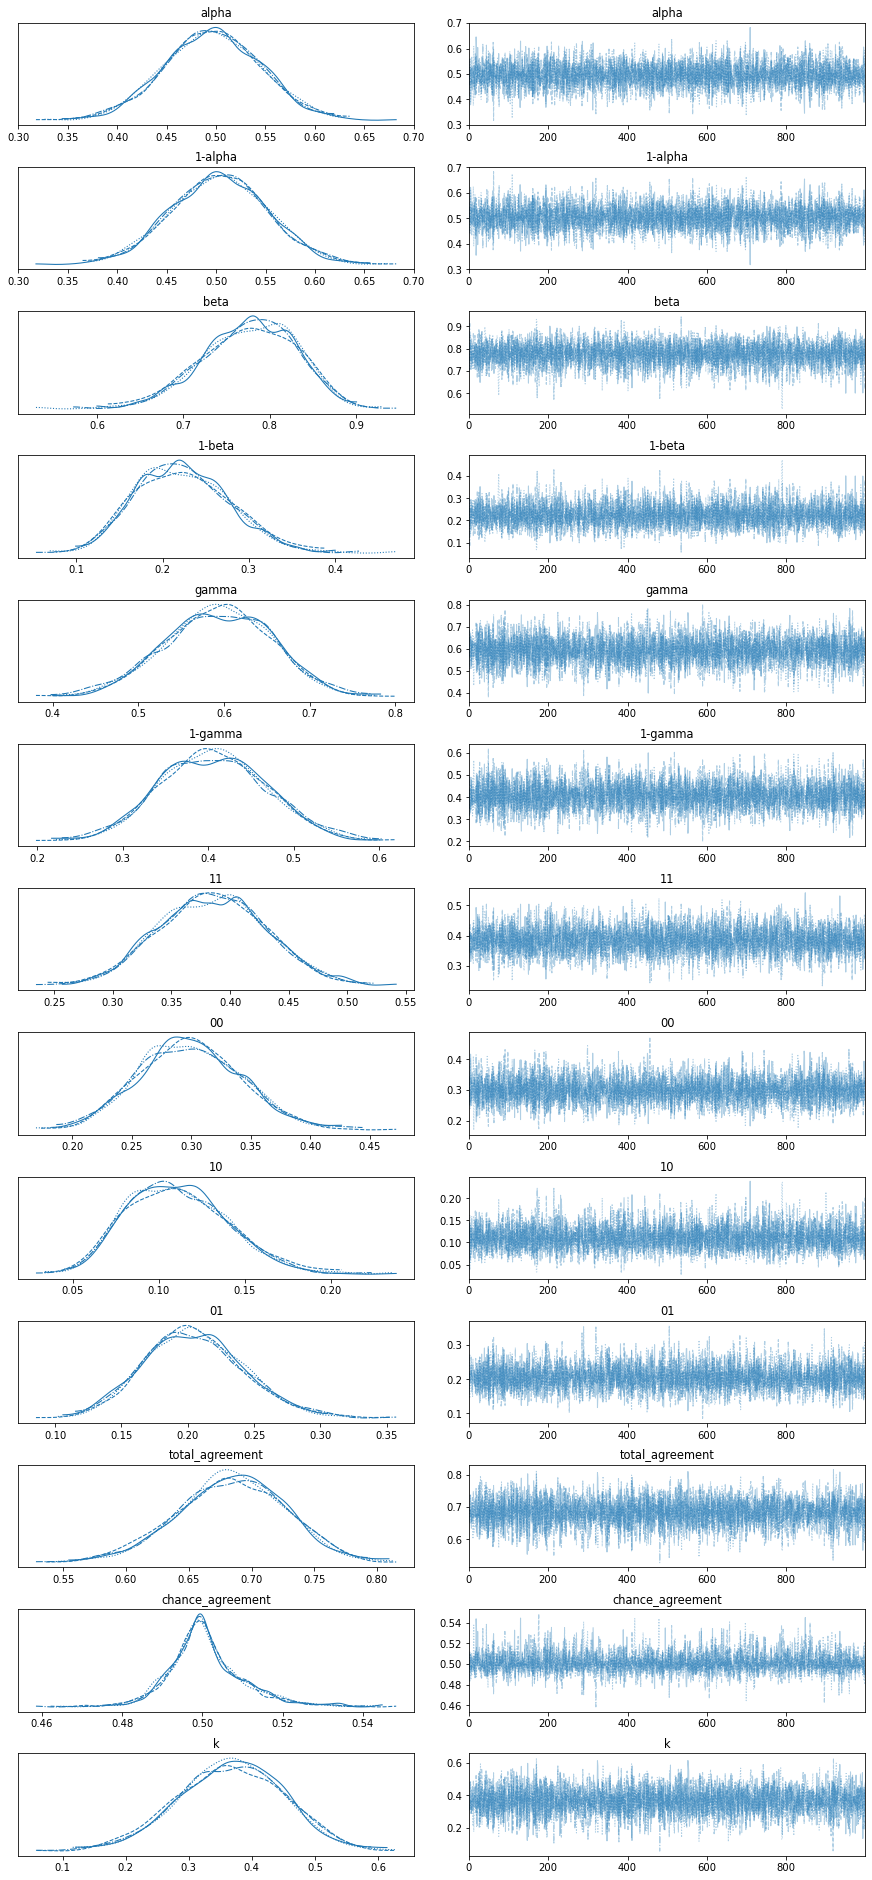

In [68]:
obs_frequencies = np.array([40, 30, 8, 19])

model = estimate_k_coef_agreement(
    obs_frequencies=obs_frequencies, 
    alpha=5,
    beta=5
)
plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

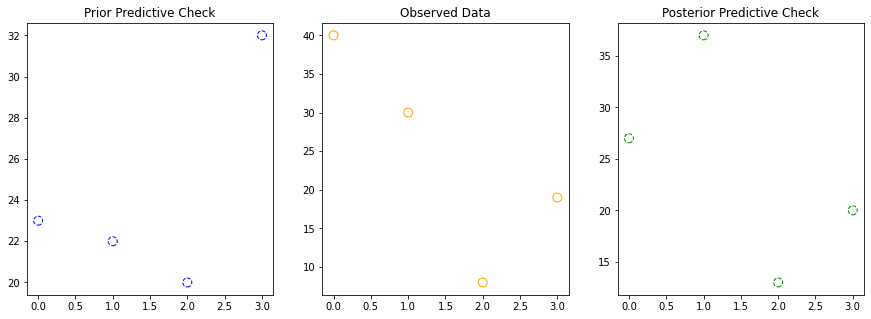

In [69]:
visualize_samples(
    observed=obs_frequencies, 
    prpc=prpc['obs_frequencies'][0, :], 
    popc=popc['obs_frequencies'][0, :],
    s=80
)

# Estimate Change Point in Time Series

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [sigma, intercepts, slope]
INFO:pymc3:>NUTS: [sigma, intercepts, slope]
>Metropolis: [change_point]
INFO:pymc3:>Metropolis: [change_point]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 47 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 47 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


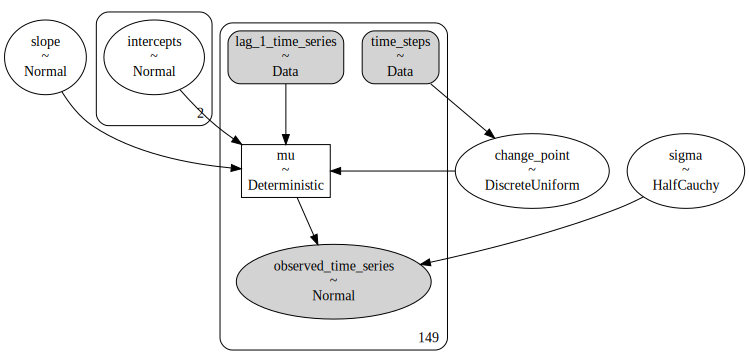

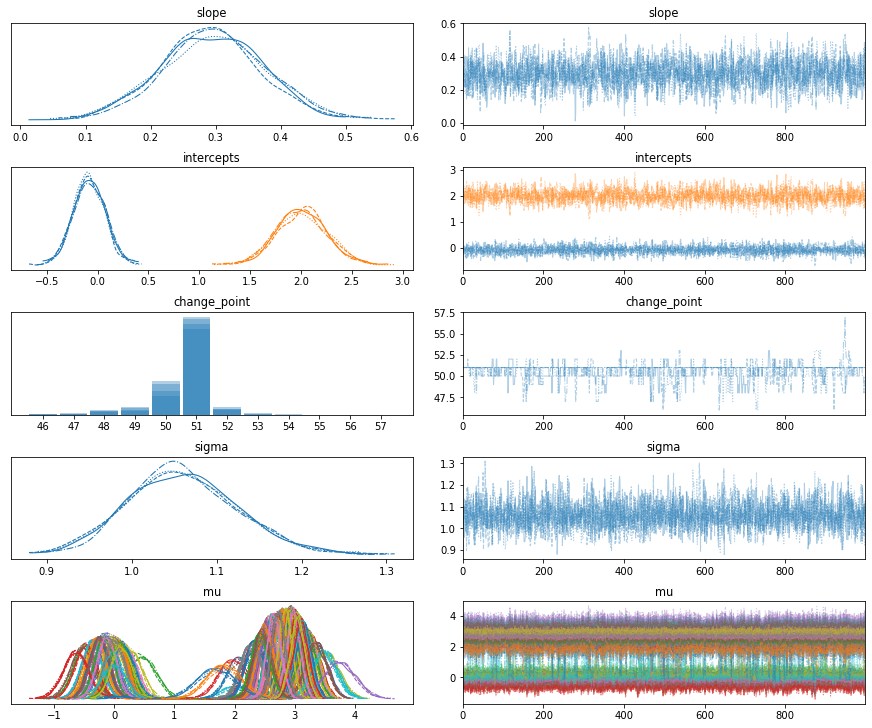

In [97]:
TS_POPC_KWARGS = {
    'samples': 1000,
    'var_names': ['observed_time_series', 'change_point']
}

t_steps = []
obs_time_series = []
slope = 0.3
change_point = 50
for t in range(150):
    
    if t == 0:
        obs_time_series.append(
            np.random.normal(0, 1) + slope * np.random.normal(0, 1)
        )
    else:
        t_steps.append(t)
        if t <= change_point:
            intercept = np.random.normal(0, 1)
        else:
            intercept = np.random.normal(2, 1)
        obs_time_series.append(
            intercept + slope * obs_time_series[t-1]
        )

t_steps = np.array(t_steps)
obs_time_series = np.array(obs_time_series)
        
model = estimate_change_point(
    obs_time_series=obs_time_series, 
    t_steps=t_steps,
    slope_kwargs={
        'mu': 0,
        'sigma': 1
    },
    intercept_kwargs={
        'mu': 0,
        'sigma': 5
    },
    sigma_kwargs={
        'beta': 25
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    TS_POPC_KWARGS
)
plate

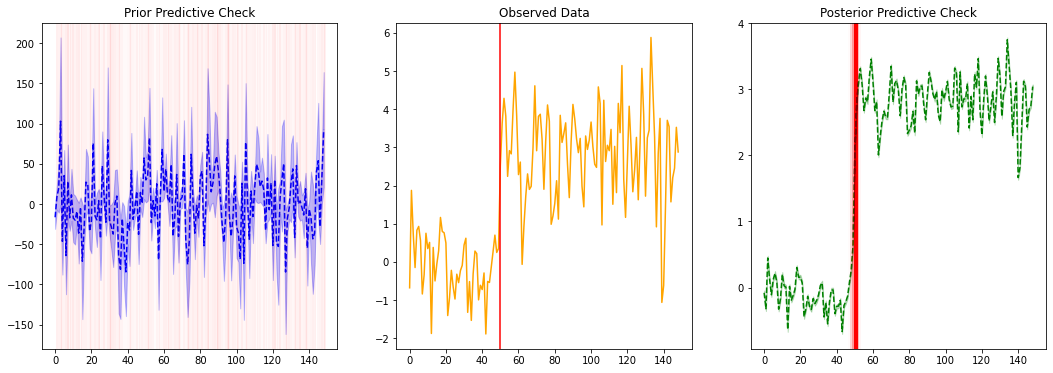

In [98]:
visualize_time_series(
    obs_time_series[1:], 
    prpc=prpc['observed_time_series'], 
    popc=popc['observed_time_series'], 
    change_points=[prpc['change_point'], 50, popc['change_point']],
    figsize=(18, 6)
)